<a href="https://colab.research.google.com/github/Rawan-Ahmed-Mohamed/Astro-Website/blob/main/Baseball_Or_Space.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
!pip install -q wordcloud gradio joblib
# (pandas, sklearn, tensorflow, matplotlib usually مثبتة في Colab)


In [37]:
# cell: load imports + data
import re, os, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gradio as gr

# Load 2 categories from 20newsgroups
categories = ['rec.sport.baseball', 'sci.space']
data = fetch_20newsgroups(subset='all', categories=categories, remove=('headers','footers','quotes'))
df = pd.DataFrame({'text': data.data, 'label': data.target})
label_map = {0: 'Baseball', 1: 'Space'}
df['label_name'] = df['label'].map(label_map)
print("Loaded dataset shape:", df.shape)


Loaded dataset shape: (1981, 3)


label_name
Baseball    994
Space       987
Name: count, dtype: int64
Text length stats:
 count    1981.000000
mean      157.292781
std       372.283498
min         0.000000
25%        36.000000
50%        78.000000
75%       156.000000
max      9113.000000
Name: text_len, dtype: float64


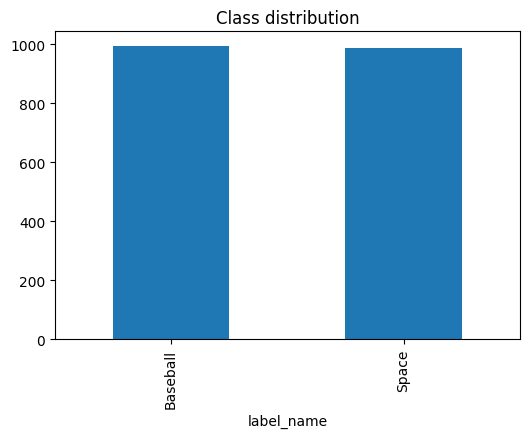

Top 20 words: [('the', 16493), ('and', 6155), ('that', 3602), ('for', 2894), ('you', 2003), ('this', 1918), ('have', 1813), ('are', 1744), ('was', 1719), ('with', 1588), ('but', 1494), ('not', 1451), ('they', 1321), ('space', 1298), ('from', 1184), ('would', 1134), ('can', 1054), ('will', 944), ('there', 941), ('about', 863)]


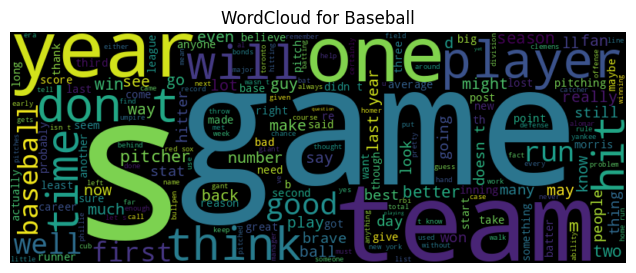

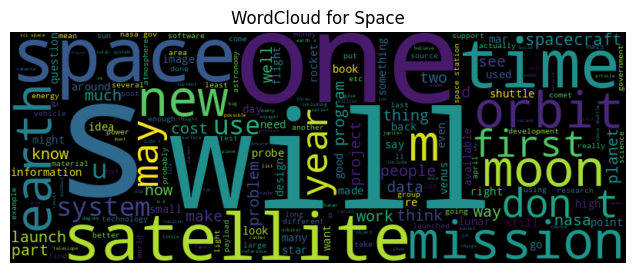

In [38]:
# EDA: distribution + lengths + top words + wordclouds
print(df['label_name'].value_counts())
df['text_len'] = df['text'].apply(lambda x: len(str(x).split()))
print("Text length stats:\n", df['text_len'].describe())

# Class distribution bar plot
plt.figure(figsize=(6,4))
df['label_name'].value_counts().plot(kind='bar')
plt.title("Class distribution")
plt.show()

# top words
def simple_tokenize(txt):
    txt = re.sub(r'[^a-zA-Z\s]', ' ', str(txt))
    return [t for t in txt.lower().split() if len(t)>2]

all_words = []
df['text'].apply(lambda x: all_words.extend(simple_tokenize(x)))
from collections import Counter
print("Top 20 words:", Counter(all_words).most_common(20))

# wordcloud per class
for lbl in df['label'].unique():
    txt = " ".join(df[df['label']==lbl]['text'].astype(str).values)
    wc = WordCloud(width=800, height=300).generate(re.sub(r'[^a-zA-Z\s]', ' ', txt.lower()))
    plt.figure(figsize=(10,3))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud for {label_map[lbl]}")
    plt.show()


In [39]:
# Preprocessing
def clean_text(text):
    if not isinstance(text, str):
        text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['text'].apply(clean_text)
X = df['clean_text'].values
y = df['label'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print("Train / Test sizes:", len(X_train), len(X_test))


Train / Test sizes: 1584 397


In [40]:
# TF-IDF + LR, SVM (GridSearch small)
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))

pipe_lr = Pipeline([('tfidf', tfidf), ('clf', LogisticRegression(max_iter=200, random_state=42))])
pipe_svm = Pipeline([('tfidf', tfidf), ('clf', SVC(kernel='linear', probability=True, random_state=42))])

from sklearn.model_selection import GridSearchCV
print("GridSearch LR...")
params_lr = {'clf__C': [0.1, 1, 5]}
gs_lr = GridSearchCV(pipe_lr, params_lr, cv=3, scoring='f1', n_jobs=2)
gs_lr.fit(X_train, y_train)
print("LR best:", gs_lr.best_params_)

print("GridSearch SVM...")
params_svm = {'clf__C': [0.1, 1]}
gs_svm = GridSearchCV(pipe_svm, params_svm, cv=3, scoring='f1', n_jobs=2)
gs_svm.fit(X_train, y_train)
print("SVM best:", gs_svm.best_params_)


GridSearch LR...
LR best: {'clf__C': 5}
GridSearch SVM...
SVM best: {'clf__C': 1}


In [41]:
# Tokenizer + padding for LSTM
MAX_WORDS = 10000
MAX_LEN = 200
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Tokenizer vocab size:", len(tokenizer.word_index))
print("Train pad shape:", X_train_pad.shape)


Tokenizer vocab size: 17152
Train pad shape: (1584, 200)


In [42]:
def build_lstm_model(vocab_size=MAX_WORDS, embed_dim=64, lstm_units=64):
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = build_lstm_model()
lstm_model.summary()

es = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
chkpt_path = "best_lstm.h5"
mc = ModelCheckpoint(chkpt_path, monitor='val_loss', save_best_only=True)

history = lstm_model.fit(
    X_train_pad, y_train,
    validation_split=0.15,
    epochs=10,
    batch_size=64,
    callbacks=[es, mc],
    verbose=1
)

# load best weights
lstm_model = load_model(chkpt_path)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.5052 - loss: 0.6918

22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.5064 - loss: 0.6917 - val_accuracy: 0.6176 - val_loss: 0.6772
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7064 - loss: 0.6120

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.7065 - loss: 0.6117 - val_accuracy: 0.6723 - val_loss: 0.6453
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.8280 - loss: 0.5862

22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - accuracy: 0.8296 - loss: 0.5851 - val_accuracy: 0.8193 - val_loss: 0.5345
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.8706 - loss: 0.3974

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.8717 - loss: 0.3948 - val_accuracy: 0.8319 - val_loss: 0.3809
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.9258 - loss: 0.2073

22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - accuracy: 0.9260 - loss: 0.2065 - val_accuracy: 0.9076 - val_loss: 0.2330
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.9603 - loss: 0.1183

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step - accuracy: 0.9603 - loss: 0.1179 - val_accuracy: 0.9202 - val_loss: 0.1968
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 161ms/step - accuracy: 0.9645 - loss: 0.0823 - val_accuracy: 0.8992 - val_loss: 0.2434
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9772 - loss: 0.0552

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 165ms/step - accuracy: 0.9772 - loss: 0.0551 - val_accuracy: 0.9202 - val_loss: 0.1795
Epoch 9/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.9730 - loss: 0.0624

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 195ms/step - accuracy: 0.9730 - loss: 0.0625 - val_accuracy: 0.9328 - val_loss: 0.1434
Epoch 10/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9764 - loss: 0.0484 - val_accuracy: 0.9328 - val_loss: 0.1790


=== LogisticRegression_TFIDF ===
              precision    recall  f1-score   support

    Baseball       0.92      0.95      0.94       199
       Space       0.95      0.91      0.93       198

    accuracy                           0.93       397
   macro avg       0.94      0.93      0.93       397
weighted avg       0.94      0.93      0.93       397

Confusion matrix:
 [[190   9]
 [ 17 181]]

=== SVM_TFIDF ===
              precision    recall  f1-score   support

    Baseball       0.91      0.95      0.93       199
       Space       0.95      0.91      0.93       198

    accuracy                           0.93       397
   macro avg       0.93      0.93      0.93       397
weighted avg       0.93      0.93      0.93       397

Confusion matrix:
 [[189  10]
 [ 18 180]]

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 95ms/step
=== LSTM ===
              precision    recall  f1-score   support

    Baseball       0.89      0.96      0.92       199
       Space       0.96      0.88      0.92    

,model,accuracy,precision,recall,f1,roc_auc
0,LogisticRegression_TFIDF,0.934509,0.952632,0.914141,0.932990,0.986168
1,SVM_TFIDF,0.929471,0.947368,0.909091,0.927835,0.986219
2,LSTM,0.919395,0.956044,0.878788,0.915789,0.983047


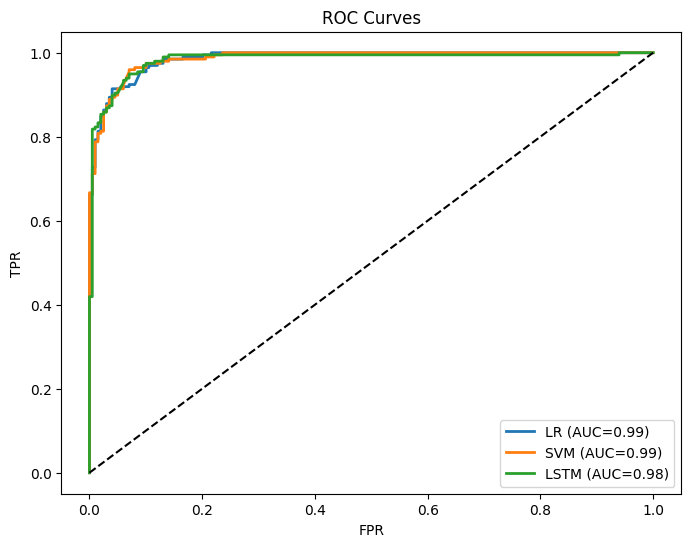

In [43]:
# Evaluate helper
results = []
def eval_and_store(name, y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_proba) if y_proba is not None else None
    results.append({'model':name,'accuracy':acc,'precision':prec,'recall':rec,'f1':f1,'roc_auc':roc})
    print(f"=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=['Baseball','Space']))
    print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print()

# LR
y_pred_lr = gs_lr.predict(X_test)
y_proba_lr = gs_lr.predict_proba(X_test)[:,1]
eval_and_store('LogisticRegression_TFIDF', y_test, y_pred_lr, y_proba_lr)

# SVM
y_pred_svm = gs_svm.predict(X_test)
y_proba_svm = gs_svm.predict_proba(X_test)[:,1]
eval_and_store('SVM_TFIDF', y_test, y_pred_svm, y_proba_svm)

# LSTM
y_proba_lstm = lstm_model.predict(X_test_pad).ravel()
y_pred_lstm = (y_proba_lstm > 0.5).astype(int)
eval_and_store('LSTM', y_test, y_pred_lstm, y_proba_lstm)

# Save comparison CSV
results_df = pd.DataFrame(results).sort_values('f1', ascending=False)
results_df.to_csv("model_comparison_results.csv", index=False)
display(results_df)

# Plot ROC curves
plt.figure(figsize=(8,6))
for name, y_t, y_p in [('LR', y_test, y_proba_lr), ('SVM', y_test, y_proba_svm), ('LSTM', y_test, y_proba_lstm)]:
    fpr, tpr, _ = roc_curve(y_t, y_p)
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC={auc(fpr,tpr):.2f})')
plt.plot([0,1],[0,1],'k--')
plt.legend()
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curves')
plt.show()


In [44]:
# Save models & tokenizer
os.makedirs('models', exist_ok=True)
joblib.dump(gs_lr.best_estimator_, 'models/logreg_tfidf.pkl')
joblib.dump(gs_svm.best_estimator_, 'models/svm_tfidf.pkl')
lstm_model.save('models/lstm_model.h5')
joblib.dump(tokenizer, 'models/tokenizer.pkl')
print("Saved models to /models")


Saved models to /models


In [45]:
def unit_tests():
    assert df['clean_text'].isnull().sum() == 0, "Nulls in clean_text!"
    assert len(tokenizer.word_index) > 100, "Tokenizer vocab too small"
    m1 = joblib.load('models/logreg_tfidf.pkl')
    p1 = m1.predict_proba(["this is a test about baseball"])[:,1]
    assert p1.shape[0] == 1
    m2 = load_model('models/lstm_model.h5')
    seq = pad_sequences(tokenizer.texts_to_sequences(["this is a test about space"]), maxlen=MAX_LEN)
    p2 = m2.predict(seq)
    assert p2.shape == (1,1)
    print("All unit tests passed!")

unit_tests()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
All unit tests passed!


In [46]:
# load artifacts
loaded_lr = joblib.load('models/logreg_tfidf.pkl')
loaded_svm = joblib.load('models/svm_tfidf.pkl')
loaded_lstm = load_model('models/lstm_model.h5')
tok = joblib.load('models/tokenizer.pkl')

def predict_text(text, model_choice='LogisticRegression_TFIDF'):
    text_clean = clean_text(text)
    if model_choice == 'LogisticRegression_TFIDF':
        proba = loaded_lr.predict_proba([text_clean])[:,1][0]
        label = 'Space' if proba > 0.5 else 'Baseball'
        return label, float(proba)
    elif model_choice == 'SVM_TFIDF':
        proba = loaded_svm.predict_proba([text_clean])[:,1][0]
        label = 'Space' if proba > 0.5 else 'Baseball'
        return label, float(proba)
    else:
        seq = pad_sequences(tok.texts_to_sequences([text_clean]), maxlen=MAX_LEN)
        proba = loaded_lstm.predict(seq)[0][0]
        label = 'Space' if proba > 0.5 else 'Baseball'
        return label, float(proba)

iface = gr.Interface(
    fn=predict_text,
    inputs=[gr.Textbox(lines=4, placeholder="اكتب نص هنا..."),
            gr.Dropdown(['LogisticRegression_TFIDF','SVM_TFIDF','LSTM'], value='LogisticRegression_TFIDF')],
    outputs=[gr.Textbox(label="Predicted Label"), gr.Number(label="Confidence (Space prob)")],
    title="News Category Classifier",
    description="اختر نموذجًا ثم ضع نص للتصنيف."
)

# شغّلها في Colab بتمرير share=True
iface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ca1fd42ad49fe2d51e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
